# <b>The Movie recommender system</b>
- The movie recommender system is used to recommend movies to users based on the movies' features and the users activity. 
- We would enter a name for the movie and the recommender system would recommend the related movies to us

#### <b>Steps involved</b>
- First we clean the datasets and create a single dataset that includes only the necessary columns in them
- We use normal EDA processes to analyze the dataset
- We perform bayesian average on ratings.
- Data pre-processing and Machine Learning

<b>For a given movie, The movie recommender may use one of the two techniques</b>
1) <b>The Collaborative Filtering:</b> suggests movies by finding similarities in user's ratings to movies of same kind. And also how other users have rated to same movie and relating them.

1) <b>The Content-based Filtering:</b> suggests movies by taking the movies' features like genre, year and compare it with that of the users preference of that feature

We will work on both types of filtering in this project

I'm using the MovieLens dataset which has about 100836 ratings for about 9742 movies. i've already tried to create this system with the Movielens 2M dataset. But my computer cannot compute that much load. So i will stick with the small dataset for now. And, if you did'nt find all your favourite movies, remember that a movie would be present here if and only if it had been rated by anyone.
- Credits to Toronto Machine Learning channel whose webinar featuring Jill Cates provided with the great help to create this recommender.

## Import the necessary modules
- Some modules are imported between the project on the go. 
- I recommend to install "fuzzywuzzy" module from pip using `pip install fuzzywuzzy` on the terminal. You will use it later

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

## Read the datasets

In [12]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

### Basic analysis of the databases
#### The movies dataset

In [13]:
movies = movies.drop_duplicates() # there was probably no duplicates
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [14]:
movies.info() # all the datatypes are good
movies.isnull().sum() # no null values either

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


movieId    0
title      0
genres     0
dtype: int64

In [15]:
# lets clean the genres column
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))

#### <b>The ratings dataset</b>

In [16]:
ratings = ratings.drop_duplicates() # there were no duplicates as well
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [17]:
ratings.isnull().sum() # no null values in this dataset
ratings.info() # All good. I guess i dont need to change the timestamp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


## Exploratory Data Analysis (EDA)
- Lets perform EDA and find useful information from the dataset

In [18]:
n_movies = ratings['movieId'].nunique() # total no of unique movies in the ratings dataset. 
n_users = ratings['userId'].nunique() # Total no of unique users ratings in the dataset

print(f'Total no of users: {n_users}')
print(f'Total no of movies: {n_movies}')
print(f'\nAverage ratings per movie: {round(len(ratings['movieId'])/n_movies,3)}')
print(f'Average ratings per user: {round(len(ratings['userId'])/n_users,3)}')


Total no of users: 610
Total no of movies: 9724

Average ratings per movie: 10.37
Average ratings per user: 165.305


Text(0.5, 1.0, 'Distribution of Movie ratings')

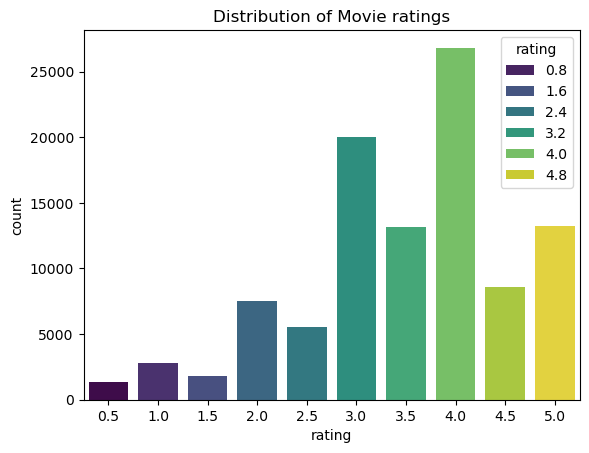

In [19]:
# Lets see a Quick visual of the distribution of ratings
sns.countplot(
    x='rating',
    data=ratings,
    palette='viridis',
    hue='rating')
plt.title('Distribution of Movie ratings')

looks like more people tend to give fair to good ratings for the movies

In [20]:
print(f'Mean ratings of movies taken globally: {round(ratings['rating'].mean(),3)}')

Mean ratings of movies taken globally: 3.502


In [21]:
mean_user_ratings = ratings.groupby(by='userId')['rating'].mean() # grouped by User id. Gives the avg rating of every user in the ratings df
print(f'average user rating: {round(mean_user_ratings.mean(),2)}') 

average user rating: 3.66


In [22]:
n_ratings_per_movie = ratings['movieId'].value_counts().reset_index() # grouped by movieId. Gives the frequency of rating of every movie
n_ratings_per_movie.merge(movies[['title','movieId']],on='movieId')[0:10]

,movieId,count,title
0,356,329,Forrest Gump (1994)
1,318,317,"Shawshank Redemption, The (1994)"
2,296,307,Pulp Fiction (1994)
3,593,279,"Silence of the Lambs, The (1991)"
4,2571,278,"Matrix, The (1999)"
5,260,251,Star Wars: Episode IV - A New Hope (1977)
6,480,238,Jurassic Park (1993)
7,110,237,Braveheart (1995)
8,589,224,Terminator 2: Judgment Day (1991)
9,527,220,Schindler's List (1993)


`Forrest Gump`, `The Shawshank Redemption(1994)`, `Pulp Fiction` have the most amount of ratings. 

(Note: they are not the highest rated movies, not yet)

#### <b>Highest and Lowest rated movies</b>

In [23]:
avg_ratings = ratings.groupby(by='movieId')[['rating']].mean()
avg_ratings = avg_ratings.merge(movies[['movieId','title']],on='movieId')

# get the id of the lowest rated movie using idxmin() and print out the movie using iloc
lowest_rated_movie = avg_ratings['rating'].idxmin()
print(f'The lowest rated movie is: {avg_ratings.iloc[2685]['title']}')

# get the id of the highest rated movie using idxmax() and print out the movie using iloc
highest_rated_movie = avg_ratings['rating'].idxmax() 
print(f'The highest rated movie is: {avg_ratings.iloc[48]['title']}')

The lowest rated movie is: Gypsy (1962)
The highest rated movie is: Lamerica (1994)


But this is not the actual ratings of the movies. these are the simple average of the movies. 
we cannot consider this rating as the actual rating. Because
1) If a movie has an average rating of 4.3 out of 300 ratings, you can conclude that it has been viewed by many people and has a genuine review
2) But if another movie has rating of 5 out of only 3 ratings, you cannot be sure about the movie's goodness
3) That is if a movie has only one 5 star rating, it would simply be the best movie out of everything.

A bayesian Avg would be the proper solution for this problem

#### <b>Calculating the Bayesian average for every movie.</b>
<b>formula for bayesian average</b> = C * M + (sum(x1 + x2 + x3 + ... + xn)) / c + n
where:
- <b>C</b> = it is the sample taken from the population or confidence ( in our case, The mean number of ratings per movie )
- <b>M</b> = it is the simple mean of the total population ( the mean of all the ratings of all movies combined )
- <b>xn</b> = they are the sum of individual ratings ( In our case,, all the ratings for a given movie, even if its just 1 )
- <b>n</b> = total count of values in the list

In [24]:
# Create the movie stats df which contains the no of ratings for a movie, their simple avg of their ratings and the bayesian avg of every movie
# the bayesian avg must be calculated for each movie.
movie_stats = ratings.groupby(by='movieId')['rating'].agg(['count','mean'])
C = movie_stats['count'].mean()
M = movie_stats['mean'].mean()

print(f'The average number of ratings for a given movie: {C:.4f}')
print(f'The average rating for a given movie: {M:.4f}')

# create the function to calculate bayesian avg
def bayesian_avg(rating):
    bayesian_value = (C * M + (rating.sum())) / (C + rating.count())
    return bayesian_value


The average number of ratings for a given movie: 10.3698
The average rating for a given movie: 3.2624


In [25]:
# now we find the bayesian values for every movie on the ratings table. \
bayesian_values = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()

# add those values to the movie stats dataframe
movie_stats = movie_stats.merge(bayesian_values,on='movieId')

# we dont need the simple averaga anymore
movie_stats.drop(columns='mean',inplace=True)
# rename the columns
movie_stats.columns = ['movieId','count','bayesian avg ratng']
# merge the movie titles to the movie stats dataframe
movie_stats = movie_stats.merge(movies[['title','movieId']],on='movieId')
movie_stats

,movieId,count,bayesian avg ratng,title
0,1,215,3.890632,Toy Story (1995)
1,2,110,3.417227,Jumanji (1995)
2,3,52,3.260086,Grumpier Old Men (1995)
3,4,7,2.897612,Waiting to Exhale (1995)
4,5,49,3.104793,Father of the Bride Part II (1995)
...,...,...,...,...
9719,193581,1,3.327318,Black Butler: Book of the Atlantic (2017)
9720,193583,1,3.283341,No Game No Life: Zero (2017)
9721,193585,1,3.283341,Flint (2017)
9722,193587,1,3.283341,Bungo Stray Dogs: Dead Apple (2018)


<b> Top 10 Movies of this dataset </b>
- Unlike the simple mean, now we can be assured that all movies will get ratings properly

In [52]:
movie_stats.sort_values(by='bayesian avg ratng',ascending=False).head(10)
# movie_stats.sort_values(by='bayesian avg ratng',ascending=True).head(10)

,movieId,count,bayesian avg ratng,title
277,318,317,4.392070,"Shawshank Redemption, The (1994)"
659,858,192,4.236457,"Godfather, The (1972)"
2224,2959,218,4.227052,Fight Club (1999)
224,260,251,4.192646,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.190567,"Usual Suspects, The (1995)"
921,1221,129,4.185490,"Godfather: Part II, The (1974)"
461,527,220,4.181672,Schindler's List (1993)
913,1213,126,4.174905,Goodfellas (1990)
6693,58559,149,4.174762,"Dark Knight, The (2008)"
897,1196,211,4.170989,Star Wars: Episode V - The Empire Strikes Back...


So these are the top most rated movies. which makes sense. Because, these are most popular movies of all time

In [51]:
# we find the highest and the lowest rated movies now
best_rated = movie_stats['bayesian avg ratng'].idxmax()
worst_rated = movie_stats['bayesian avg ratng'].idxmin()

print(f'The best rated movie of this dataset is: {movies.iloc[best_rated]['title']}')
print(f'The worst rated movie of this dataset is: {movies.iloc[worst_rated]['title']}')

The best rated movie of this dataset is: Shawshank Redemption, The (1994)
The worst rated movie of this dataset is: Pillow Book, The (1996)


#### <b>Working with the movie Genres</b>
Lets filter using genres of movies and analyze the information

In [28]:
# lets check the frequency of genres in the dataset. We use Counter() from python collections

genre_count = Counter(g for genres in movies['genres'] for g in genres)
print('There are',len(genre_count),'categories of genres')
genre_count

There are 20 categories of genres


Counter({'Drama': 4361,
         'Comedy': 3756,
         'Thriller': 1894,
         'Action': 1828,
         'Romance': 1596,
         'Adventure': 1263,
         'Crime': 1199,
         'Sci-Fi': 980,
         'Horror': 978,
         'Fantasy': 779,
         'Children': 664,
         'Animation': 611,
         'Mystery': 573,
         'Documentary': 440,
         'War': 382,
         'Musical': 334,
         'Western': 167,
         'IMAX': 158,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [29]:
# lets check the most common genres of the dataset
print('These are the most common movie genres in the dataset')
genre_count.most_common(5)

These are the most common movie genres in the dataset


[('Drama', 4361),
 ('Comedy', 3756),
 ('Thriller', 1894),
 ('Action', 1828),
 ('Romance', 1596)]

,genre,frequency
6,Drama,4361
3,Comedy,3756
9,Thriller,1894
7,Action,1828
5,Romance,1596
0,Adventure,1263
8,Crime,1199
12,Sci-Fi,980
10,Horror,978
4,Fantasy,779


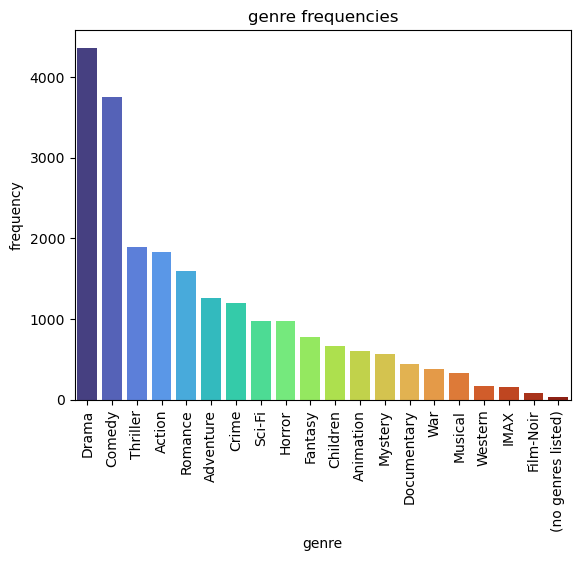

In [54]:
genre_df = pd.DataFrame({'genre':genre_count.keys(),'frequency': genre_count.values()})
sns.barplot(
    data = genre_df.sort_values(by='frequency',ascending = False),
    x = 'genre',
    y = 'frequency',
    hue = 'genre',
    palette = 'turbo'
)
plt.title('genre frequencies')
plt.xticks(rotation = 90)
genre_df.sort_values('frequency',ascending=False)
# I dont know why these arrays are being printed above the plot :(

## <b>Creating the Movie Recommender</b>
The creation of the movie recommender system involves many sub processes. 
### <b>Data pre-processing</b>
#### <b>Creating the Sparse matrix.</b>
The sparse matrix is a matrix that has
- user Id on the rows
- movie Id on the columns
- the values are the ratings of movies by each user

To create the matrix, we need four mappers

- <b>movie_mapper</b> = maps the movie Id to the movie index
- <b>movie_inv_mapper</b> = maps the movie index to the movie ID
- <b>user_mapper</b> = maps the user Id to the user index
- <b>user_inv_mapper</b> = maps the user index to the user Id



In [31]:
from scipy.sparse import csr_matrix
# create a function that converts a dataframe to a matrix X
def create_X(df):
    # create two variables to store unique users and movies
    m = df['userId'].nunique() # 610
    n = df['movieId'].nunique() # 9724

    # the mapper functions map the Id with their Indices
    user_mapper = dict(zip(np.unique(df['userId']),list(range(m))))
    movie_mapper = dict(zip(np.unique(df['movieId']),list(range(n)))) # Keys and values are sorted

    # the inverse mapper functions map the indices with their Id
    user_inv_mapper = dict(zip(list(range(m)),np.unique(df['userId']))) 
    movie_inv_mapper = dict(zip(list(range(n)),np.unique(df['movieId']))) # keys and values are sorted
    # movie_inv_mapper = create_inv_mapper(movie_mapper)
    # user_inv_mapper = create_inv_mapper(user_mapper)

    # storing the index of the users and movies on a separate variable
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']] # values are not sorted

    # Create the sparse matrix
    X = csr_matrix((df['rating'],(user_index,movie_index)),shape = [m,n])

    return X, movie_mapper, movie_inv_mapper, user_mapper, user_inv_mapper

X, movie_mapper, movie_inv_mapper, user_mapper, user_inv_mapper = create_X(ratings)


In [32]:
# movie_inv_mapper
def create_inv_mapper(mapper):
    inv_mapper = {}
    for key,value in mapper.items():
        key_inv = value
        value_inv = key
        inv_mapper[key_inv] = value_inv
    return inv_mapper
movie_inv_mapper_2 = create_inv_mapper(movie_mapper)


#### <b>Evaluating sparsity of the matrix</b>

- Sparsity of the matrix is the metric to measure the no of empty cella in the sparse matrix
- The value of the sparse matrix can be between 0 to 2. abbove or below would lead to unexpected results

sparsity = no of non-empty cells / total no of cells

In [33]:
n_cells = X.shape[0] * X.shape[1]
filled_cells = X.nnz

# the get.nnz function of the matrix is used to find the no of non-empty cells along an axis, or the whole df if necessary
sparsity = filled_cells/n_cells
print(f'The sparsity of the matrix is: {(sparsity * 100):.2f}')

The sparsity of the matrix is: 1.70


In [34]:
# n_ratings_by_user is a list of no of ratings of each user in the matrix
n_ratings_by_user = X.getnnz(axis = 1)
print(f'The most active user has rated about {n_ratings_by_user.max()} movies')
print(f'The least active user has rated about {n_ratings_by_user.min()} movies')

The most active user has rated about 2698 movies
The least active user has rated about 20 movies


In [35]:
# n_ratings_by_movie is a list of no_of ratings given to all movies
n_ratings_by_movie = X.getnnz(axis = 0)
print(f'The most rated movie has about {n_ratings_by_movie.max()} ratings')
print(f'The least rated movie has about {n_ratings_by_movie.min()} ratings')

The most rated movie has about 329 ratings
The least rated movie has about 1 ratings


#### <b>Collaborative Filtering</b>
### FInding similar movies using the k-nearest neighbors
- We use the scikit-learn's Nearestneighbors library
- The steps are as follows
    - First we transpose the matrix so that the Knearestneighbors() model works with the movies instead of movies
    - We create an empty list to enter all the nearest neighbours from the implementation
    - first we find the movie_vector which is simple the row of the movie in the sparse matrix
    - We do that by getting the index of the movie using our movie mapper
    - we reshape the vector in a way that it has only one row and n-columns (1,-1) would do the trick
    - now we initialize the model and insert the vector into the model
    - we create a neighbor variable that is an array of all the nearest movie Ids in the graph
    - Then we pop the needed amount of movie Ids from the neighbors array and append it to the empty list we created earlier
    - Then we return that list of movie Ids


In [36]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movieIds(movie_id, X, movie_mapper, movie_inv_mapper, k, metric = 'cosine'):
    # transpose the sparse matrix X
    X = X.T
    similar_Ids = []
    # identifying the movie vector using the movie mapper
    movie_index = movie_mapper[movie_id]
    movie_vec = X[movie_index]
    # reshape the movie vector
    if isinstance(movie_vec,(np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # initialize the model
    KNN = NearestNeighbors(n_neighbors= k + 1 ,algorithm='brute', metric = metric) # initializing the model
    KNN.fit(X) # fitting the matrix for the model to understand it
    neighbors = KNN.kneighbors(movie_vec, return_distance = False) # Then find the neighbours for the given vector
    for i in range(0, k+1):
        n = neighbors.item(i)
        similar_Ids.append(movie_inv_mapper[n])
    similar_Ids.pop(0)

    return similar_Ids

# find_similar_movieIds(1, X, movie_mapper, movie_inv_mapper, k, metric = 'cosine')

In [55]:
movie_titles = dict(zip(movies['movieId'],movies['title']))

def find_similar_movies(movieId,k=10):
    crnt_movie = movie_titles[movieId]
    movies_list = []
    similar_ids = find_similar_movieIds(movieId, X, movie_mapper, movie_inv_mapper,k = k)
    print(f'Since you have watched {crnt_movie}, you may like:\n')
    for i in similar_ids:
        print(movie_titles[i])
find_similar_movies(1)

Since you have watched Toy Story (1995), you may like:

Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)
Back to the Future (1985)


In [38]:
# def movie_recommendations(title):
#     moviename = moviename_finder(title)
#     print(moviename)
#     movie_index = movies_idx[moviename]
#     print(movie_index)
#     movie_id = movie_mapper[movie_index]
#     print(movie_id)
#     # find_similar_movies(movieId = movie_id)
# movie_recommendations('Jumanji')

### <b>Content based filtering</b>
In content based filtering we use the cosine similarity of different movies and calculate the movie with highest similarity to the given movie
- First we take all the unique genres from the dataframe
- We find the cosine similarity for each genre

This way, if a horror movie is selected, all movies with horror as the genre will score higher than other movies.

In [39]:
genres = set(g for genres in movies['genres'] for g in genres)
for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))
movie_genres = movies.drop(columns= ['movieId','title','genres'])

- The recommender system takes in only movie IDs. We are not supposed to remember the movie Id of every movie in the MovieLens Database. 
- And also, the movie titles in the dataset has the release year attached to it (eg - Blade Runner (1982))
- In order to solve this problem, we use 'fuzzywuzzy'.

fuzzywuzzy is a python module that is very useful for searching for movies names.
- This function recieves a list of all movie names
- Then it compares the given title with all other titles and return the closst name to the search word given
- For example, 'enterstellar' would return 'Interstellar'

And then we can find the id of that movie using movie_titles dictionary

In [40]:
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import process

cosine_sim = cosine_similarity(movie_genres,movie_genres)

def moviename_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

c:\Users\sakir\apps\anaconda\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [41]:
# methods dump. These are the codes for testing the steps. i have included all these in the main function.

title = moviename_finder('Interstellar')
movies_idx = dict(zip(movies['title'], list(movies.index)))
idx = movies_idx[title]
n_recommendations = 10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse = True)
sim_scores = sim_scores[1:n_recommendations+1]
movie_ids = [i[0] for i in sim_scores]
for i in movie_ids:
    print(movies.iloc[i]['title'])

# these are recommendations for Interstellar

Monsters vs. Aliens (2009)
Contagion (2011)
Cloud Atlas (2012)
Gravity (2013)
The Amazing Spider-Man 2 (2014)
Transcendence (2014)
Edge of Tomorrow (2014)
2010: The Year We Make Contact (1984)
Meteor (1979)
It Came from Outer Space (1953)


### <b>The Movie Recommender System</b>
So, we created the movie recommender system. THe name of the function is:

<b>movie_recommendations()</b>
- The parameters are the movie title and the 'no_of_recomm' which is the no of recommendations you need


In [42]:
# Content_based filtering
def movie_recommendations(title,no_of_recomm = 10):
    moviename = moviename_finder(title)
    idx = movies_idx[moviename]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:no_of_recomm+1]
    movie_ids = [i[0] for i in sim_scores]
    print(f'Since you watched {moviename}\n')
    for i in movie_ids:
        print(movies.iloc[i]['title'])

In [71]:
# lets test our recommender system. 
movie_recommendations('matrix')

Since you watched Matrix, The (1999)

Screamers (1995)
Johnny Mnemonic (1995)
Virtuosity (1995)
Timecop (1994)
Blade Runner (1982)
Solo (1996)
Arrival, The (1996)
Terminator, The (1984)
Godzilla (1998)
Matrix, The (1999)
